<h1>Recurrent Neural Networks (RNN) for Time Series Forecasting</h1>

<h2>LSTM vs GRU Comparison</h2>

<p><b>Code written by Seetha Parameswaran</b></p>

<hr>

<h3>Overview</h3>
<p>This exercise demonstrates <b>RNN architectures for time series forecasting</b> using TensorFlow/Keras. We compare LSTM and GRU with stacked layers on multivariate→univariate prediction tasks.</p>

<h4>RNN Components:</h4>
<ul>
  <li><b>LSTM</b>: Long Short-Term Memory with forget, input, output gates</li>
  <li><b>GRU</b>: Gated Recurrent Unit (simpler, fewer parameters)</li>
  <li><b>Stacked layers</b>: Multiple RNN layers with return_sequences=True</li>
  <li><b>Temporal split</b>: NO shuffling (preserves time order)</li>
</ul>

<hr>

<h3>Learning Outcomes</h3>
<ul>
  <li>✓ Build stacked LSTM and GRU models</li>
  <li>✓ Create sequences for time series prediction</li>
  <li>✓ Apply proper temporal train/test split</li>
  <li>✓ Compare LSTM vs GRU performance</li>
  <li>✓ Evaluate with MAE, RMSE, MAPE, R²</li>
  <li>✓ Visualize predictions and residuals</li>
</ul>

<hr>

<h3>Architecture</h3>
<pre>
Input (seq_length, n_features)
   ↓
LSTM/GRU (64 units, return_sequences=True)
   ↓
Dropout (0.2)
   ↓
LSTM/GRU (32 units)
   ↓
Dropout (0.2)
   ↓
Dense (1) [univariate output]
</pre>

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
import random
import warnings
warnings.filterwarnings('ignore')

2026-01-13 09:20:20.427751: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-13 09:20:20.428098: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-13 09:20:20.472894: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-13 09:20:21.519196: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-poin

In [2]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## PART 1: LOAD AND PREPROCESS TIME SERIES DATA

In [3]:
print("\n[1] Loading time series dataset...")

# For this demo, we'll use energy consumption data
# You can replace with: stock prices, weather data, sensor data, etc.

# Generate synthetic multivariate time series data
# Features: temperature, humidity, day_of_week (simulating energy consumption)
np.random.seed(42)
n_samples = 2000
time = np.arange(n_samples)

# Feature 1: Temperature (seasonal pattern)
temperature = 20 + 10 * np.sin(2 * np.pi * time / 365) + np.random.randn(n_samples) * 2

# Feature 2: Humidity (with trend)
humidity = 60 + 0.005 * time + 10 * np.sin(2 * np.pi * time / 180) + np.random.randn(n_samples) * 3

# Feature 3: Day of week (cyclic)
day_of_week = np.sin(2 * np.pi * time / 7)

# Target: Energy consumption (depends on temperature and humidity)
energy = (50 + 0.5 * temperature + 0.3 * humidity + 
          5 * np.sin(2 * np.pi * time / 7) + np.random.randn(n_samples) * 5)

# Create DataFrame
data = pd.DataFrame({
    'temperature': temperature,
    'humidity': humidity,
    'day_of_week': day_of_week,
    'energy': energy
})

print(f"Dataset shape: {data.shape}")
print(f"Features: {list(data.columns)}")
print(f"\nFirst few rows:")
print(data.head())

# Basic statistics
print(f"\nDataset Statistics:")
print(data.describe())


[1] Loading time series dataset...
Dataset shape: (2000, 4)
Features: ['temperature', 'humidity', 'day_of_week', 'energy']

First few rows:
   temperature   humidity  day_of_week     energy
0    20.993428  57.974465     0.000000  73.571586
1    19.895605  59.920439     0.781831  81.677074
2    21.639593  58.330305     0.974928  83.283612
3    23.562256  60.136400     0.433884  84.354619
4    20.219718  55.730887    -0.433884  67.825414

Dataset Statistics:
       temperature     humidity   day_of_week       energy
count  2000.000000  2000.000000  2.000000e+03  2000.000000
mean     20.668330    65.010074  8.783797e-04    79.601551
std       7.303520     7.968029  7.070844e-01     7.593761
min       3.721328    44.612623 -9.749279e-01    53.305582
25%      13.883493    58.710106 -7.818315e-01    74.497413
50%      21.226710    65.245417 -2.106516e-14    79.744807
75%      27.188082    71.322981  7.818315e-01    84.809367
max      35.465001    84.714069  9.749279e-01   107.246483


## PART 2: TIME SERIES EXPLORATION AND VISUALIZATION


[2] Visualizing time series data...


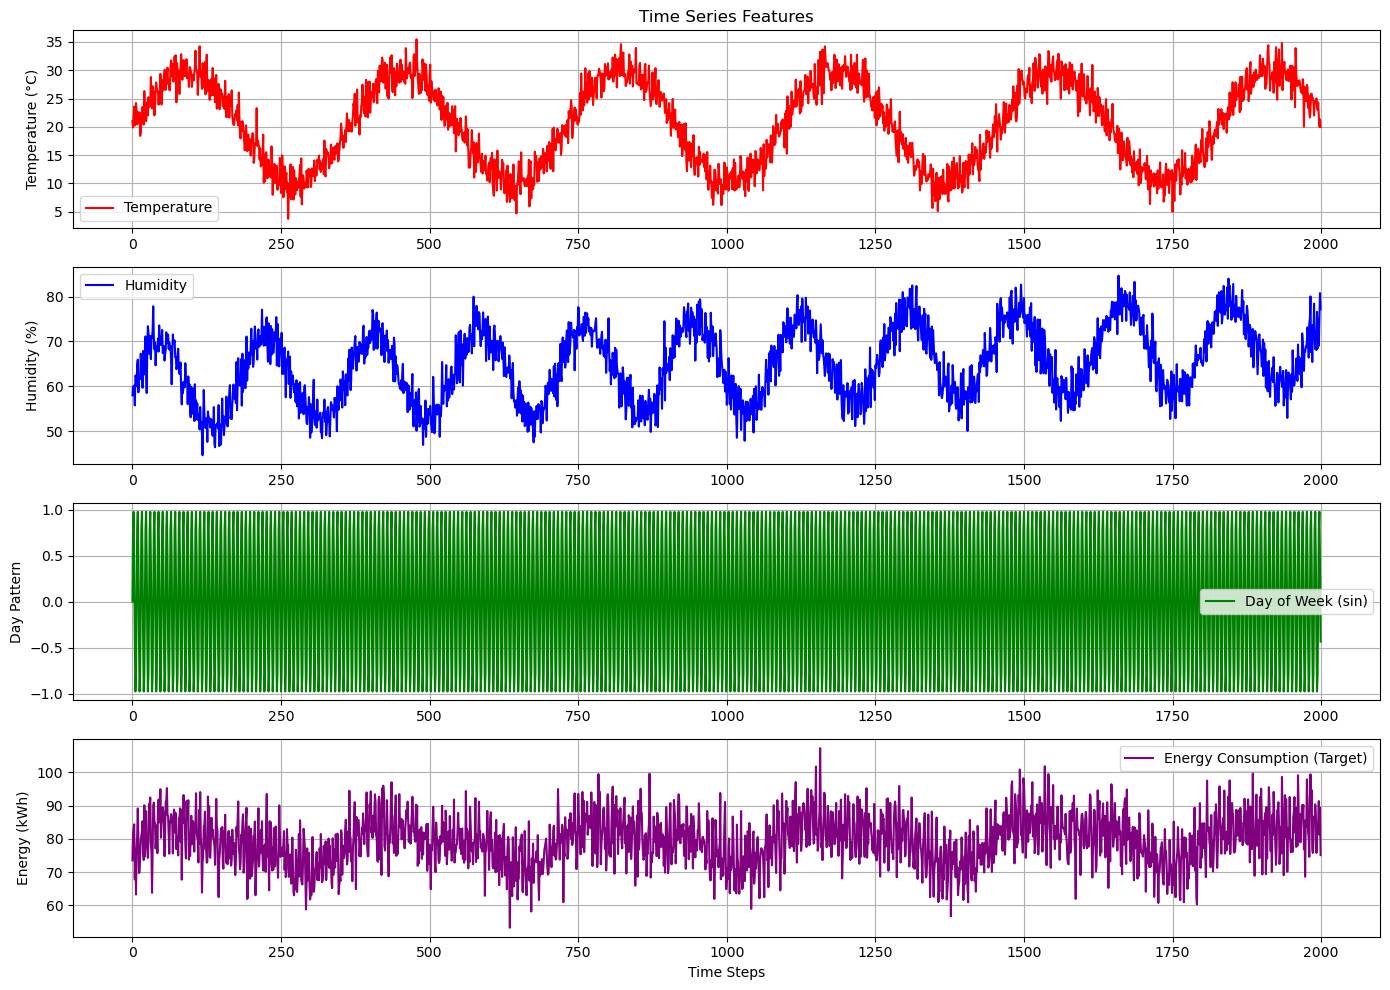

In [4]:
print("\n[2] Visualizing time series data...")

fig, axes = plt.subplots(4, 1, figsize=(14, 10))

axes[0].plot(data['temperature'], label='Temperature', color='red')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Time Series Features')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(data['humidity'], label='Humidity', color='blue')
axes[1].set_ylabel('Humidity (%)')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(data['day_of_week'], label='Day of Week (sin)', color='green')
axes[2].set_ylabel('Day Pattern')
axes[2].legend()
axes[2].grid(True)

axes[3].plot(data['energy'], label='Energy Consumption (Target)', color='purple')
axes[3].set_ylabel('Energy (kWh)')
axes[3].set_xlabel('Time Steps')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()

## PART 3: DATA PREPROCESSING

In [5]:
print("\n[3] Preprocessing time series data...")

# Normalize features using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale features (temperature, humidity, day_of_week)
X_scaled = scaler_X.fit_transform(data[['temperature', 'humidity', 'day_of_week']])

# Scale target (energy)
y_scaled = scaler_y.fit_transform(data[['energy']])

print(f"Scaled data shape: X={X_scaled.shape}, y={y_scaled.shape}")

# Create sequences for time series prediction
def create_sequences(X, y, seq_length, pred_horizon=1):
    """
    Create sequences for time series forecasting
    
    Args:
        X: input features (n_samples, n_features)
        y: target values (n_samples, 1)
        seq_length: lookback window
        pred_horizon: forecast steps ahead
    
    Returns:
        X_seq: input sequences (n_sequences, seq_length, n_features)
        y_seq: target values (n_sequences, pred_horizon)
    """
    X_seq, y_seq = [], []
    
    for i in range(len(X) - seq_length - pred_horizon + 1):
        # Input: sequence of past features
        X_seq.append(X[i:i + seq_length])
        # Output: future target value(s)
        y_seq.append(y[i + seq_length:i + seq_length + pred_horizon])
    
    return np.array(X_seq), np.array(y_seq)

# Configuration
sequence_length = 30  # Look back 30 time steps
prediction_horizon = 1  # Predict 1 step ahead (univariate output)

# Create sequences
X_sequences, y_sequences = create_sequences(X_scaled, y_scaled, sequence_length, prediction_horizon)

print(f"\nSequence shapes:")
print(f"X_sequences: {X_sequences.shape} (samples, seq_length, n_features)")
print(f"y_sequences: {y_sequences.shape} (samples, pred_horizon)")

# Temporal train/test split (NO SHUFFLING)
train_size = int(0.9 * len(X_sequences))
X_train, X_test = X_sequences[:train_size], X_sequences[train_size:]
y_train, y_test = y_sequences[:train_size], y_sequences[train_size:]

print(f"\nTrain/Test Split (90/10 temporal):")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print("IMPORTANT: Temporal split used (NO shuffling)")


[3] Preprocessing time series data...
Scaled data shape: X=(2000, 3), y=(2000, 1)

Sequence shapes:
X_sequences: (1970, 30, 3) (samples, seq_length, n_features)
y_sequences: (1970, 1, 1) (samples, pred_horizon)

Train/Test Split (90/10 temporal):
Training samples: 1773
Test samples: 197
IMPORTANT: Temporal split used (NO shuffling)


## PART 4: BUILD AND TRAIN LSTM MODEL

In [6]:
print("LSTM MODEL") 

# Build stacked LSTM model
lstm_model = Sequential([
    # First LSTM layer (return sequences for stacking)
    LSTM(64, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
    Dropout(0.2),
    
    # Second LSTM layer
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    
    # Output layer
    Dense(prediction_horizon)
])

# Compile model
lstm_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print("\nLSTM Architecture:")
lstm_model.summary()

LSTM MODEL

LSTM Architecture:


E0000 00:00:1768296036.663950     165 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1768296036.695875     165 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train LSTM model
print("\n[4] Training LSTM model...")
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=0
)


[4] Training LSTM model...


In [8]:
# Track initial and final loss
lstm_initial_loss = lstm_history.history['loss'][0]
lstm_final_loss = lstm_history.history['loss'][-1]

print(f"Initial Loss: {lstm_initial_loss:.6f}")
print(f"Final Loss: {lstm_final_loss:.6f}")
print(f"Loss Decreased: {lstm_final_loss < lstm_initial_loss}")

Initial Loss: 0.025700
Final Loss: 0.009774
Loss Decreased: True


## PART 5: BUILD AND TRAIN GRU MODEL

In [9]:
print("GRU MODEL") 

# Build stacked GRU model
gru_model = Sequential([
    # First GRU layer (return sequences for stacking)
    GRU(64, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
    Dropout(0.2),
    
    # Second GRU layer
    GRU(32, return_sequences=False),
    Dropout(0.2),
    
    # Output layer
    Dense(prediction_horizon)
])

# Compile model
gru_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print("\nGRU Architecture:")
gru_model.summary()

GRU MODEL

GRU Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 64)         │        13,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,689 (88.63 KB)

 Trainable params: 22,689 (88.63 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train GRU model
print("\n[5] Training GRU model...")
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=0
)


[5] Training GRU model...


In [11]:
# Track initial and final loss
gru_initial_loss = gru_history.history['loss'][0]
gru_final_loss = gru_history.history['loss'][-1]

print(f"Initial Loss: {gru_initial_loss:.6f}")
print(f"Final Loss: {gru_final_loss:.6f}")
print(f"Loss Decreased: {gru_final_loss < gru_initial_loss}")

Initial Loss: 0.034453
Final Loss: 0.009776
Loss Decreased: True


## PART 6: EVALUATE MODELS

In [13]:
print("\n[6] Evaluating models on test set...")

# LSTM predictions
lstm_pred_scaled = lstm_model.predict(X_test, verbose=0)
lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled.reshape(-1, 1))

# Actual values
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# GRU predictions
gru_pred_scaled = gru_model.predict(X_test, verbose=0)
gru_pred = scaler_y.inverse_transform(gru_pred_scaled.reshape(-1, 1))


[6] Evaluating models on test set...


In [14]:
# Calculate metrics for LSTM
def calculate_mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

lstm_mae = mean_absolute_error(y_test_actual, lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_pred))
lstm_mape = calculate_mape(y_test_actual, lstm_pred)
lstm_r2 = r2_score(y_test_actual, lstm_pred)

# Calculate metrics for GRU
gru_mae = mean_absolute_error(y_test_actual, gru_pred)
gru_rmse = np.sqrt(mean_squared_error(y_test_actual, gru_pred))
gru_mape = calculate_mape(y_test_actual, gru_pred)
gru_r2 = r2_score(y_test_actual, gru_pred)

print("MODEL PERFORMANCE COMPARISON")
print(f"{'Metric':<15} {'LSTM':<15} {'GRU':<15} {'Better':<10}")
print("-"*70)
print(f"{'MAE':<15} {lstm_mae:<15.4f} {gru_mae:<15.4f} {'LSTM' if lstm_mae < gru_mae else 'GRU':<10}")
print(f"{'RMSE':<15} {lstm_rmse:<15.4f} {gru_rmse:<15.4f} {'LSTM' if lstm_rmse < gru_rmse else 'GRU':<10}")
print(f"{'MAPE (%)':<15} {lstm_mape:<15.4f} {gru_mape:<15.4f} {'LSTM' if lstm_mape < gru_mape else 'GRU':<10}")
print(f"{'R² Score':<15} {lstm_r2:<15.4f} {gru_r2:<15.4f} {'LSTM' if lstm_r2 > gru_r2 else 'GRU':<10}")



MODEL PERFORMANCE COMPARISON
Metric          LSTM            GRU             Better    
----------------------------------------------------------------------
MAE             4.7109          4.7021          GRU       
RMSE            5.8973          5.8682          GRU       
MAPE (%)        5.7405          5.7077          GRU       
R² Score        0.2552          0.2625          GRU       


## PART 7: VISUALIZATIONS


[7] Generating visualizations...


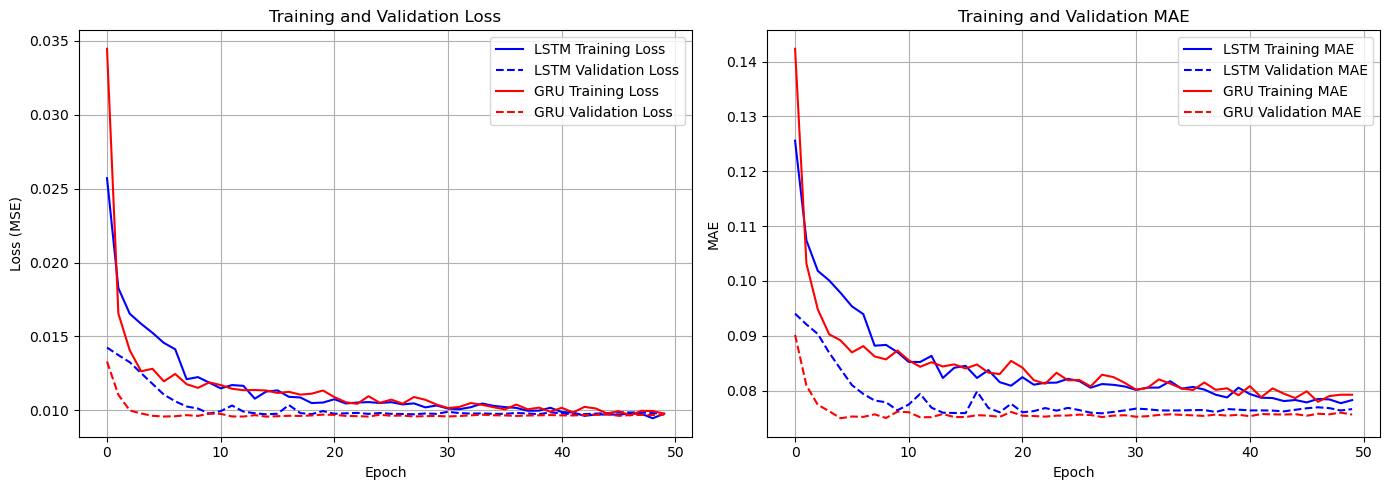

In [15]:
print("\n[7] Generating visualizations...")

# Plot training history comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss comparison
axes[0].plot(lstm_history.history['loss'], label='LSTM Training Loss', color='blue')
axes[0].plot(lstm_history.history['val_loss'], label='LSTM Validation Loss', color='blue', linestyle='--')
axes[0].plot(gru_history.history['loss'], label='GRU Training Loss', color='red')
axes[0].plot(gru_history.history['val_loss'], label='GRU Validation Loss', color='red', linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# MAE comparison
axes[1].plot(lstm_history.history['mae'], label='LSTM Training MAE', color='blue')
axes[1].plot(lstm_history.history['val_mae'], label='LSTM Validation MAE', color='blue', linestyle='--')
axes[1].plot(gru_history.history['mae'], label='GRU Training MAE', color='red')
axes[1].plot(gru_history.history['val_mae'], label='GRU Validation MAE', color='red', linestyle='--')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Training and Validation MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

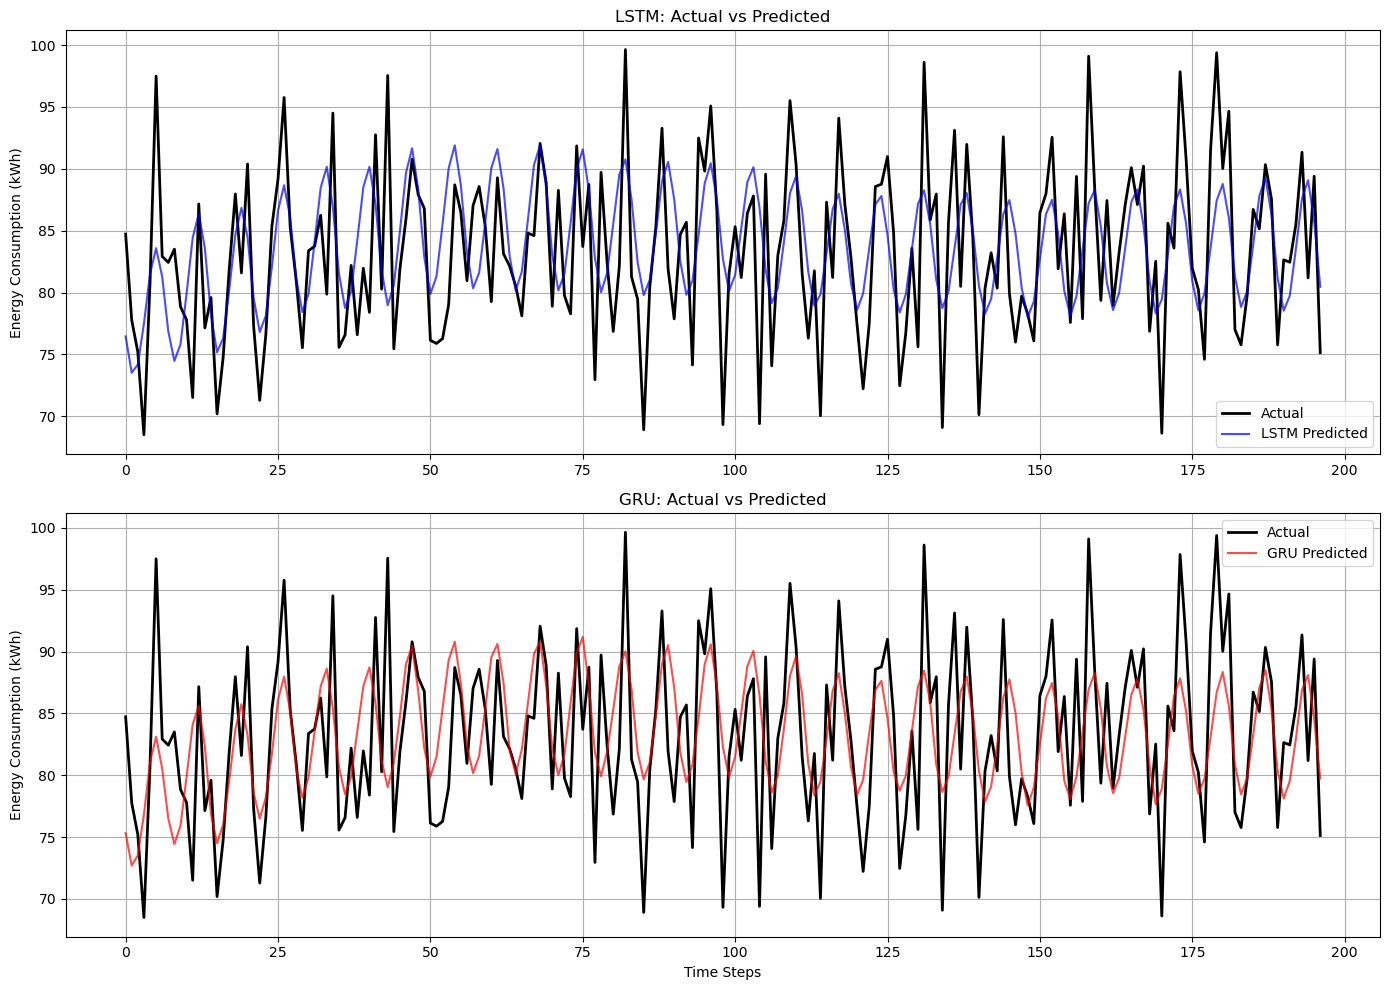

In [16]:
# Plot actual vs predicted
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# LSTM predictions
axes[0].plot(y_test_actual, label='Actual', color='black', linewidth=2)
axes[0].plot(lstm_pred, label='LSTM Predicted', color='blue', alpha=0.7)
axes[0].set_ylabel('Energy Consumption (kWh)')
axes[0].set_title('LSTM: Actual vs Predicted')
axes[0].legend()
axes[0].grid(True)

# GRU predictions
axes[1].plot(y_test_actual, label='Actual', color='black', linewidth=2)
axes[1].plot(gru_pred, label='GRU Predicted', color='red', alpha=0.7)
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Energy Consumption (kWh)')
axes[1].set_title('GRU: Actual vs Predicted')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

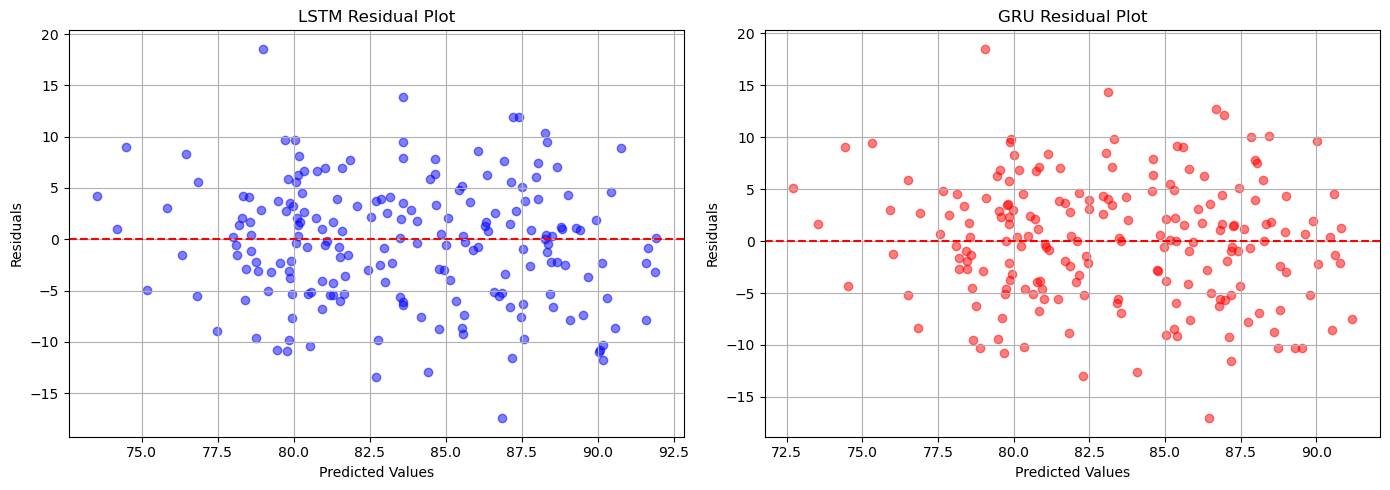

In [17]:
# Plot residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LSTM residuals
lstm_residuals = y_test_actual.flatten() - lstm_pred.flatten()
axes[0].scatter(lstm_pred, lstm_residuals, alpha=0.5, color='blue')
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('LSTM Residual Plot')
axes[0].grid(True)

# GRU residuals
gru_residuals = y_test_actual.flatten() - gru_pred.flatten()
axes[1].scatter(gru_pred, gru_residuals, alpha=0.5, color='red')
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('GRU Residual Plot')
axes[1].grid(True)

plt.tight_layout()

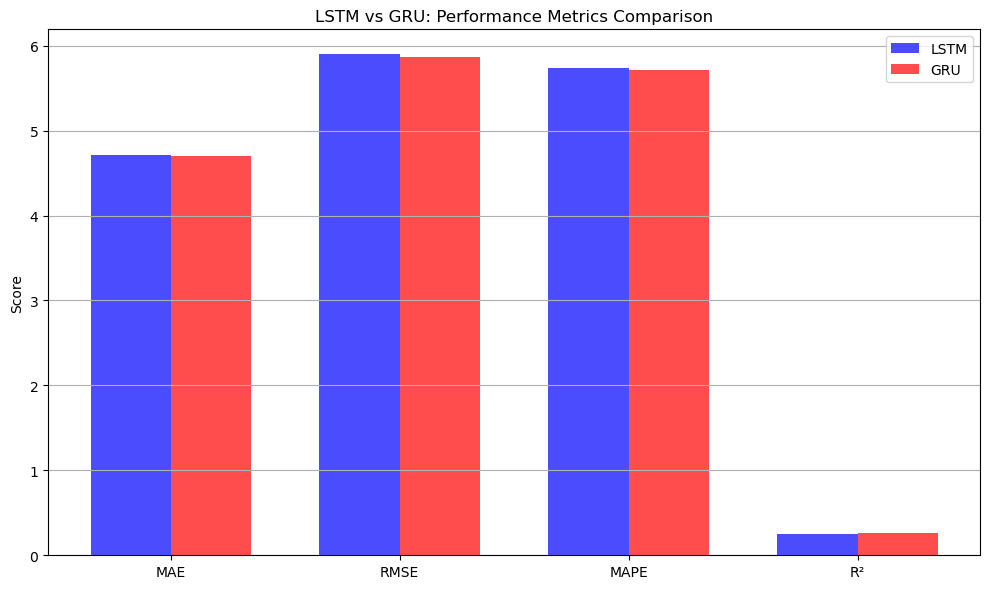

In [18]:
# Metrics comparison bar chart
fig, ax = plt.subplots(figsize=(10, 6))
metrics = ['MAE', 'RMSE', 'MAPE', 'R²']
lstm_scores = [lstm_mae, lstm_rmse, lstm_mape, lstm_r2]
gru_scores = [gru_mae, gru_rmse, gru_mape, gru_r2]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, lstm_scores, width, label='LSTM', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, gru_scores, width, label='GRU', color='red', alpha=0.7)

ax.set_ylabel('Score')
ax.set_title('LSTM vs GRU: Performance Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, axis='y')

plt.tight_layout()

In [19]:
print("RNN TIME SERIES FORECASTING COMPLETE") 
print(f"Architecture: Stacked (2 layers)")
print(f"Input: Multivariate (3 features)")
print(f"Output: Univariate (1 step ahead)")
print(f"LSTM Parameters: {lstm_model.count_params():,}")
print(f"GRU Parameters: {gru_model.count_params():,}")
print(f"Better Model: {'LSTM' if lstm_mae < gru_mae else 'GRU'} (lower MAE)")
print(f"Framework: TensorFlow/Keras {tf.__version__}")

RNN TIME SERIES FORECASTING COMPLETE
Architecture: Stacked (2 layers)
Input: Multivariate (3 features)
Output: Univariate (1 step ahead)
LSTM Parameters: 29,857
GRU Parameters: 22,689
Better Model: GRU (lower MAE)
Framework: TensorFlow/Keras 2.20.0


<hr style="border: 2px solid #4CAF50;"> 
<h3>Extensions and Student Exercises</h3>

<h4>1. Architecture Experiments</h4>
<ul>
  <li><b>Layer variations</b>: Try 3-4 stacked layers</li>
  <li><b>Hidden units</b>: Experiment with 32, 64, 128, 256</li>
  <li><b>Bidirectional RNN</b>: Use Bidirectional(LSTM) wrapper</li>
  <li><b>Hybrid models</b>: Combine CNN + LSTM for feature extraction</li>
</ul>

<h4>2. Sequence Configuration</h4>
<ul>
  <li><b>Lookback window</b>: Try 10, 20, 30, 60 time steps</li>
  <li><b>Prediction horizon</b>: Forecast 1, 5, 10 steps ahead</li>
  <li><b>Multi-step output</b>: Predict multiple future values</li>
  <li><b>Overlapping sequences</b>: Vary stride in sequence creation</li>
</ul>

<h4>3. Training Enhancements</h4>
<ul>
  <li><b>Early stopping</b>: Monitor validation loss</li>
  <li><b>Learning rate scheduling</b>: ReduceLROnPlateau</li>
  <li><b>Batch size tuning</b>: Test 16, 32, 64, 128</li>
  <li><b>Regularization</b>: Try L2 regularization, different dropout rates</li>
</ul>

<h4>4. Data Preprocessing</h4>
<ul>
  <li><b>Scaling methods</b>: Compare MinMax, Standard, Robust scalers</li>
  <li><b>Differencing</b>: Handle non-stationary series</li>
  <li><b>Feature engineering</b>: Add lag features, rolling statistics</li>
  <li><b>Seasonal decomposition</b>: Extract trend, seasonality</li>
</ul>

<h4>5. Apply to Real Datasets</h4>
<ul>
  <li>Stock prices (daily/hourly closing)</li>
  <li>Weather data (temperature, precipitation)</li>
  <li>Energy consumption (electricity demand)</li>
  <li>Sensor data (IoT readings)</li>
</ul>

<h4>Challenge Problems</h4>
<ol>
  <li>Achieve <b>MAPE < 5%</b> on your dataset</li>
  <li>Build <b>ensemble of LSTM + GRU</b> models</li>
  <li>Implement <b>attention mechanism</b> on RNN outputs</li>
  <li>Compare <b>RNN vs traditional methods</b> (ARIMA, Prophet)</li>
</ol>

<hr>
<h4><center>Happy coding</center></h4>